# Exponentially Weighted Moving Average (EWMA) combined with a Z-score method to detect anomalies in a real time data stream

## Imports

### Requirements

- numpy==1.24.0                     # For numerical computations
- scikit-learn==1.2.2               # For IsolationForest and Local Outlier Factor models
- statsmodels==0.13.5               # For STL decomposition (seasonal-trend decomposition)
- scipy==1.10.0                     # For z-score calculation and statistical functions
- matplotlib==3.7.0                 # For static plotting
- pandas==1.5.0                     # For data manipulation
- plotly==5.9.0                     # For interactive plotting and visualization
- ipython==8.9.0                    # For IPython display in Jupyter (clear_output)


In [5]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL
from scipy.stats import zscore
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from IPython.display import clear_output
import time


## Data Simulation

The function simulate_data_stream_with_anomalies creates a time series with seasonal patterns, noise, drift, and injected anomalies. This function is critical as it generates the synthetic data for the anomaly detection algorithm to evaluate.



In [108]:
# Set of initial parameters for data generation
np.random.seed(42)
data_length = 1000         # length of data stream 
seasonal_amplitude = 10    # seasonal amplitude for generating sine wave
noise_level = 2            # noise level for random variations
drift_rate = 0.02          # drift rate to simulate gradual trend
anomaly_percentage = 0.05  # % of data points to be anomalies

# 1. Function to simulate the continuous data stream with injected anomalies
def simulate_data_stream_with_anomalies(length, seasonal_amplitude, noise_level, drift_rate, anomaly_percentage):

    seasonal = seasonal_amplitude * np.sin(np.linspace(0, 10 * np.pi, length))
    noise = np.random.normal(0, noise_level, length)
    drift = np.linspace(0, drift_rate * length, length)
    data_stream = seasonal + noise + drift
    
    # Calculate number of anomalies(5%) and inject them randomly in the data stream
    num_anomalies = int(length * anomaly_percentage)
    anomaly_indices = np.random.choice(length, num_anomalies, replace=False)
    
    for idx in anomaly_indices:
        # Introduce a large deviation (positive or negative)
        anomaly_value = data_stream[idx] + np.random.choice([-1, 1]) * np.random.uniform(15, 25)
        data_stream[idx] = anomaly_value
    
    return data_stream, anomaly_indices


## Anomaly Detection

**The ewma_z_score_anomaly_detection function detects anomalies using the EWMA and Z-score methods:**

- Purpose: Detects trends and shifts using a moving average that adjusts quickly to recent values, i.e. Detects gradual trends or shifts and significant deviations from expected patterns.
- Mechanism: EWMA calculates a smoothed value for each data point by weighting recent observations more than older ones. 
- Thresholding with Z-score:
    - A Z-score is computed for each data point relative to the EWMA mean and a rolling standard deviation window.
    - If the absolute Z-score exceeds a predefined threshold, the point is marked as anomalous.
    - Strength: EWMA adapts well to gradual changes and quickly detects significant deviations from the expected pattern.

**High Level Overview of the algorithm**
- EWMA is calculated to smooth the data, allowing for a more stable reference point.
- Z-score evaluates how many standard deviations away a data point is from the EWMA.
- Anomalies are flagged if the Z-score exceeds the specified threshold.



Example:
data = [10, 12, 13, 11, 12, 20, 15, 16, 22, 25, 27, 30, 60, 32, 30, 34, 28, 30, 35, 31]

Here, we injected two anomalies at points 12 (60) and 16 (34), deviating significantly from the local patterns.

**Step-by-Step Explanation of our EWMA combined with Z-Score Algorithm**

**Step 1:** Initialize the EWMA with the first data point:
ewma[0] = data[0] = 10

**Step 2:** For each point, update the EWMA based on a smoothing factor alpha (let’s assume alpha = 0.2):
ewma[i] = alpha * data[i] + (1 - alpha) * ewma[i-1]
This causes recent points to weigh more in the moving average, adapting the average to new trends.

**Step 3:** Calculate the Z-score for each data point:
Calculate the rolling standard deviation of the EWMA over a specified window (e.g., last 5 points).
Compute the Z-score:
Z = (data[i] - ewma[i]) / rolling_std

**Step 4:** Compare the Z-score to a threshold (say Z = 2). If |Z| > threshold, mark it as an anomaly.

**expected output**
For data[12] = 60, the EWMA might be around 25, and the Z-score could be much higher than 2, identifying it as an anomaly.


The model's hyperparameters were tuned: the alpha value exploring 0.05 values to 0.3, threshhold values from 1.0-4.0 and the rolling window size from 5 to 50. We utilised a grid-search approach taking various combinations of each hyper params and anlysing their performance based the our ccuracy criteria: number of detected anomalies/ number of actual anomalies that we inserted into the data stream. The final accuracy was 96.15%. We also explored other data stream variations to see how our model would perform. The initial accuracy when applying it directly onto a new data stream was not good however after tuning the parameters the accuracy was back to 95% demonstrating adaptability to different data streams. 

In [136]:
# 2. Implementation of Anomaly detection using EWMA (Exponentially Weighted Moving Average) with Z-score
def ewma_z_score_anomaly_detection(data, alpha=0.18, threshold=1.8, rolling_window_size=50):
    anomalies = []
    ewma_values = []
    detected_anomalies = []  # To store detected anomalies for printing
    
    # Initialize EWMA with the first value
    ewma = data[0]
    ewma_values.append(ewma)
    
    for i in range(len(data)):
        if i > 0:
            # Update the EWMA value with smoothing
            ewma = alpha * data[i] + (1 - alpha) * ewma
            ewma_values.append(ewma)
        
        # Calculate the standard deviation based on a rolling window of EWMA
        if i < rolling_window_size:
            rolling_std = np.std(data[:i + 1])
        else:
            rolling_std = np.std(data[i - rolling_window_size + 1:i + 1])

        # Calculate Z-score
        z_score = (data[i] - ewma) / rolling_std if rolling_std > 0 else 0
        
        # Check if the Z-score is beyond the threshold
        is_anomaly = abs(z_score) > threshold
        anomalies.append(is_anomaly)
        
        if is_anomaly:
            detected_anomalies.append((i, data[i]))  # Store index and value of detected anomalies
            
    # Print detected anomalies
    # print("Detected anomalies (index, value):")
    # for anomaly in detected_anomalies:
    #     print(anomaly)
    
    return anomalies

In [114]:
# Function to print model performance score as a measure of detected anomalies/actual anomalies
def print_performance_score(detected_anomalies, actual_anomalies):
    
    detected_set = set(np.where(detected_anomalies)[0])  # Indices of detected anomalies
    actual_set = set(actual_anomalies)                   # Indices of actual anomalies

    # Calculate detected/actual anomalies ratio
    true_positives = detected_set.intersection(actual_set)  # Correctly detected anomalies
    score = len(true_positives) / len(actual_set) if actual_set else 0

    # Print performance as a formatted string
    print(f"Model Performance: Detected {len(true_positives)}/{len(actual_set)} actual anomalies (Score: {score:.2f})")
    return len(true_positives)/len(actual_set)

## Real Time Interactive Visualization with Plotly

In [121]:
# 3. Real-Time Visualization with Plotly
def plot_real_time_full_history(data_stream, anomalies_detected, actual_anomalies, run_number, update_interval=10):
    """Real-time plot of the data stream with anomaly detection using Plotly, keeping full history."""
    fig = make_subplots(rows=1, cols=1, subplot_titles=[f"Anomaly Detection Algorithm with {run_number}% detection accuracy"])
    
    # Initialize plot traces
    fig.add_trace(go.Scatter(x=[], y=[], mode="lines", name="Data Stream"))
    fig.add_trace(go.Scatter(x=[], y=[], mode="markers", name="Detected Anomalies", marker=dict(symbol='circle', color="red", size=10)))
    fig.add_trace(go.Scatter(x=[], y=[], mode="markers", name="Actual Anomalies", marker=dict(color="blue", size=6)))

    # Full history of data, detected anomalies, and actual anomalies
    all_x = []
    all_y = []
    detected_anomaly_x = []
    detected_anomaly_y = []
    actual_anomaly_x = []
    actual_anomaly_y = []

    for i in range(len(data_stream)):
        # Append data to full history
        all_x.append(i)
        all_y.append(data_stream[i])
        
        # Add detected anomaly points
        if anomalies_detected[i]:
            detected_anomaly_x.append(i)
            detected_anomaly_y.append(data_stream[i])
        
        # Add actual anomaly points
        if i in actual_anomalies:
            actual_anomaly_x.append(i)
            actual_anomaly_y.append(data_stream[i])
        
        # Update plot at defined intervals
        if i % update_interval == 0 or i == len(data_stream) - 1:
            fig.data[0].x = all_x
            fig.data[0].y = all_y
            
            fig.data[1].x = detected_anomaly_x
            fig.data[1].y = detected_anomaly_y
            
            fig.data[2].x = actual_anomaly_x
            fig.data[2].y = actual_anomaly_y

            clear_output(wait=True)
            fig.show()
            time.sleep(0.1)  # Simulate streaming delay

## Running the algorithm

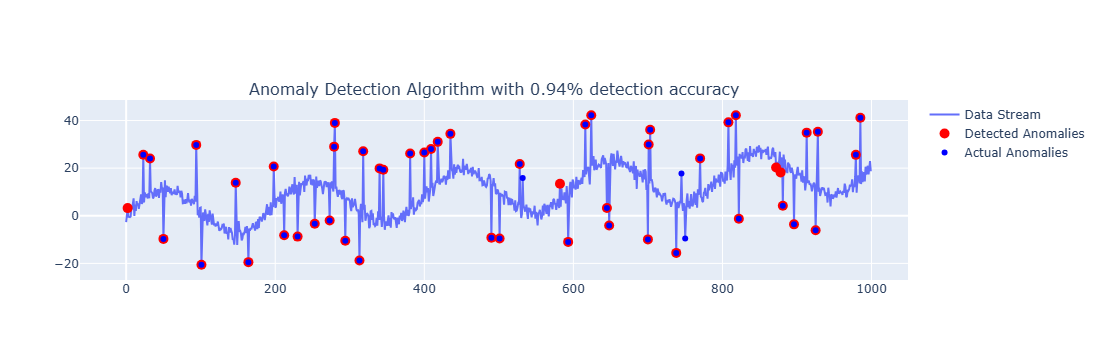

In [123]:
# Main execution with fixed parameters
def main():
    # Generate the data stream with anomalies
    data_stream, actual_anomalies = simulate_data_stream_with_anomalies(data_length, seasonal_amplitude, noise_level, drift_rate, anomaly_percentage)
    
    # Run the anomaly detection model using the fixed parameters
    anomalies_detected = ewma_z_score_anomaly_detection(data_stream)

    # Print performance score
    anomaly_score = print_performance_score(anomalies_detected, actual_anomalies)
    
    # Run real-time visualization, displaying up to 500 points for demonstration
    plot_real_time_full_history(data_stream[:1000], anomalies_detected[:1000], actual_anomalies, run_number=anomaly_score)

# Execute the main function
main()

The red circle with a blue center represents correctly identified anomalies. Red dots alone represent false positives. The graph title dynamically retrieves the accuracy of the algorithm as the number of correctly identified anomalies/ number of actual anomalies.

## Measuring Time Complexity

The time and space complexity of this algorithm depends on several key components, particularly in the data generation, anomaly detection, and visualization phases. Here's a detailed breakdown of each component:

### 1. Simulate Data Stream with Anomalies
- **Time Complexity: 𝑂(𝑛)**
    - Calculating seasonality and drift: 𝑂(𝑛)
    - Generating noise: 𝑂(𝑛)
    - Injecting anomalies: 𝑂(𝑘), where k is the number of anomalies, roughly proportional to 𝑂(𝑛) due to a fixed anomaly rate.
- **Space Complexity: 𝑂(𝑛)**
    - Storing data stream and anomalies, both requiring 𝑂(𝑛) space.

### 2. EWMA and Z-Score Anomaly Detection
- **Time Complexity: 𝑂(𝑛⋅𝑤)**
    - EWMA update at each data point: 𝑂(𝑛)
    - Calculating the rolling standard deviation with a window size 𝑤: 𝑂(𝑤) for each of the 𝑛 data points, resulting in  𝑂(𝑛⋅𝑤)
    - Calculating Z-scores and detecting anomalies both happen in constant time at each point, contributing to 𝑂(𝑛)
- **Space Complexity: 𝑂(𝑛)**
    - To store the EWMA values and detected anomalies, both requiring 
𝑂(𝑛) space.

### 3. Plot Real-Time Full History
- **Time Complexity: 𝑂(𝑛)**
    - The algorithm iterates over the entire data stream, plotting data at each point or at intervals. Plot updates at each interval are proportional to 𝑛, so the total complexity is 𝑂(𝑛).
- **Space Complexity: O(𝑛)**
    - Stores data points and detected anomalies, leading to a cumulative 𝑂(𝑛) space requirement for all data points, including plotted points.

### Total Complexity
- **Time Complexity: 𝑂(𝑛⋅𝑤)**, where w is the window size
- **Space Complexity: 𝑂(𝑛)**

In [138]:
import time

# Measure time for data simulation
start_time = time.time()
data_stream, actual_anomalies = simulate_data_stream_with_anomalies(data_length, seasonal_amplitude, noise_level, drift_rate, anomaly_percentage)
simulation_time = time.time() - start_time
print(f"Data Simulation Time: {simulation_time:.5f} seconds")

# Measure time for anomaly detection
start_time = time.time()
anomalies_detected = ewma_z_score_anomaly_detection(data_stream)
detection_time = time.time() - start_time
print(f"Anomaly Detection Time: {detection_time:.5f} seconds")

# Measure time for visualization (commented out if real-time plotting isn't desired during testing)
# start_time = time.time()
# plot_real_time_full_history(data_stream, anomalies_detected, actual_anomalies, run_number=1)
# visualization_time = time.time() - start_time
# print(f"Visualization Time: {visualization_time:.5f} seconds")


Data Simulation Time: 0.00592 seconds
Anomaly Detection Time: 0.04210 seconds


In [140]:
import sys

# Measure space for data stream
data_stream_size = sys.getsizeof(data_stream)
print(f"Data Stream Size: {data_stream_size / 1024:.2f} KB")

# Measure space for anomalies detected and actual anomalies
anomalies_detected_size = sys.getsizeof(anomalies_detected)
actual_anomalies_size = sys.getsizeof(actual_anomalies)
print(f"Detected Anomalies Size: {anomalies_detected_size / 1024:.2f} KB")
print(f"Actual Anomalies Size: {actual_anomalies_size / 1024:.2f} KB")


Data Stream Size: 7.92 KB
Detected Anomalies Size: 8.65 KB
Actual Anomalies Size: 0.11 KB


### Possible Optimizations
- Rolling Standard Deviation: Instead of calculating the rolling standard deviation in 𝑂(𝑤), you could use an online algorithm for rolling standard deviation in constant time per point, reducing the anomaly detection complexity to 𝑂(𝑛)
- Adaptive Visualization: For large data streams, updating plots less frequently or aggregating data points into larger intervals could reduce visualization overhead.

### Conclusion
The current approach, while effective in detecting straightforward anomalies, can struggle when patterns or noise levels change significantly across different scenarios. The algorithm needs to be highly optimised through hyperparameter tuning to become efficient at detecting anomalies for a given data stream with a specific pattern, drift and noise. 

Could more advanced or ensemble methods improve robustness and adaptability? At the start we looked at different algorithms for anomaly detection. What if we created a model that implemented all of them and then proceeded to define an outlier based on a voting system. Below is an extra section that investigate that theory as creating a generalised solution for detecting various data stream patterns needs a lot of fine tuning. Could we improve on this step? 

#### Algorithm Explanation
The ensemble anomaly detection algorithm integrates three primary methods to handle complex patterns in time-series data:

- **Exponential Weighted Moving Average (EWMA) with Z-Score:** Detects anomalies by analyzing deviations in smoothed values and flags points if the deviation (Z-score) exceeds a threshold.
Effectiveness: Ideal for identifying gradual changes and sudden spikes in continuous data, making it sensitive to concept drift and seasonality.
- **Isolation Forest (IF):** A tree-based algorithm that isolates anomalies by random partitioning. It scores points based on their isolation depth, with anomalies being easier to isolate.
Effectiveness: Robust for handling varied types of anomalies, particularly in high-dimensional data with random distributions.
-** # STL Residual Analysis**
- **Local Outlier Factor (LOF):** Assesses the "local density" deviation of a point compared to its neighbors, marking anomalies where the density differs significantly.
Effectiveness: Effective for datasets with varied densities, capturing subtle shifts in behavior by comparing local neighborhoods.

These components combine to form an ensemble model that enhances anomaly detection across diverse scenarios, leveraging each model's strengths to better capture seasonality, noise, and gradual drift.

Scenario 1, Best Accuracy: 0.9230767455621642
Best Parameters: Alpha=0.3631106948886222, EWMA Threshold=1.436683537180478, EWMA Window=22, IF Contamination=0.07482577111153024, STL Period=32, STL Threshold=2.284759808932835, LOF Neighbors=8


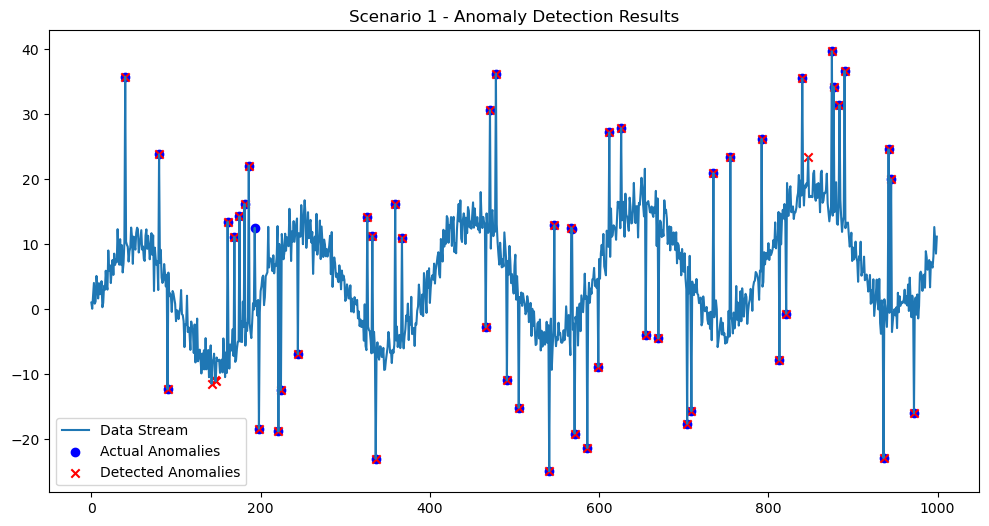

Scenario 2, Best Accuracy: 0.960784125336446
Best Parameters: Alpha=0.41238962199864787, EWMA Threshold=1.2943692452782096, EWMA Window=19, IF Contamination=0.05146497215517092, STL Period=38, STL Threshold=2.156656211256941, LOF Neighbors=5


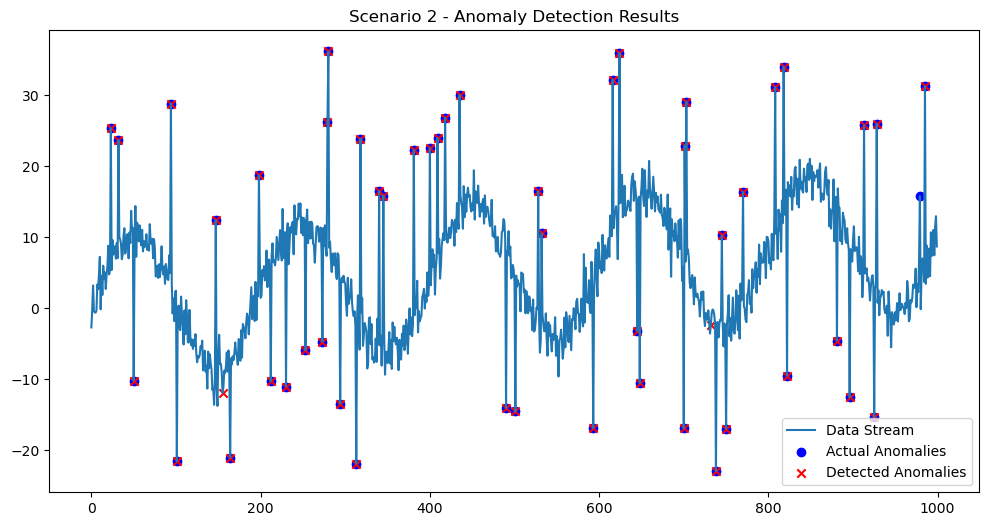

Scenario 3, Best Accuracy: 0.9615382766272544
Best Parameters: Alpha=0.3848744052107269, EWMA Threshold=1.4144088267019868, EWMA Window=26, IF Contamination=0.053289910889761954, STL Period=26, STL Threshold=2.0875714768971996, LOF Neighbors=5


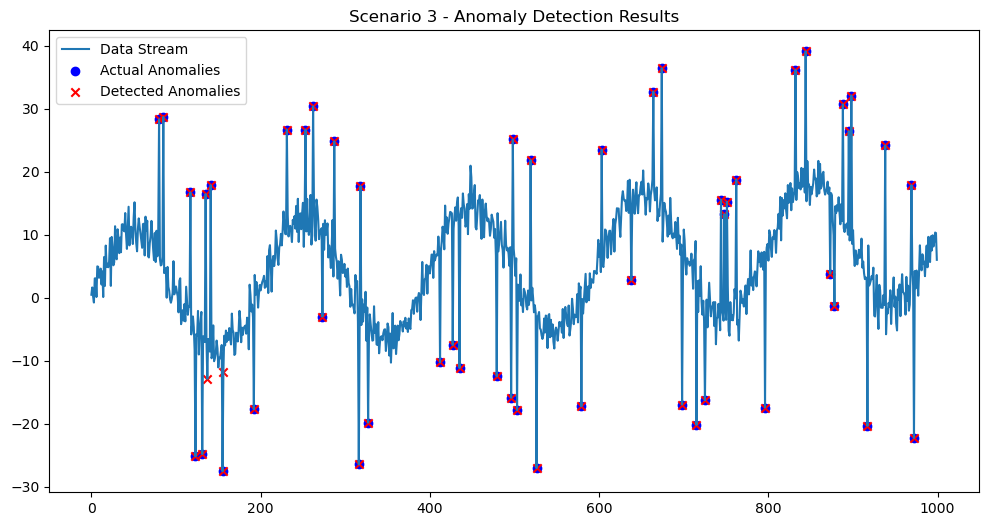

In [154]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Set parameters
np.random.seed(42)
data_length = 1000

# Generate example data scenarios
def generate_scenario_data(length, seasonal_amplitude, noise_level, drift_rate, anomaly_percentage):
    """Simulate different data streams with seasonality, noise, drift, and anomalies."""
    seasonal = seasonal_amplitude * np.sin(np.linspace(0, 10 * np.pi, length))
    noise = np.random.normal(0, noise_level, length)
    drift = np.linspace(0, drift_rate * length, length)
    data_stream = seasonal + noise + drift
    
    # Inject anomalies at random indices
    num_anomalies = int(length * anomaly_percentage)
    anomaly_indices = np.random.choice(length, num_anomalies, replace=False)
    for idx in anomaly_indices:
        data_stream[idx] += np.random.choice([-1, 1]) * np.random.uniform(15, 25)
    return data_stream, anomaly_indices

# Example scenarios
scenarios = [generate_scenario_data(data_length, 10, 2, 0.01, 0.05) for _ in range(3)]  # 3 scenarios

# Updated Ensemble Method incorporating LOF and adaptive sensitivity tuning
def ensemble_anomaly_detection(data, alpha, ewma_threshold, ewma_window, iforest_contamination, stl_period, stl_threshold, lof_n_neighbors):
    """Ensemble approach with LOF, STL residuals, Isolation Forest, and EWMA with adaptive thresholding."""
    # EWMA and Z-score Detector
    ewma_anomalies = ewma_z_score_anomaly_detection(data, alpha, ewma_threshold, ewma_window)
    
    # Isolation Forest
    iforest = IsolationForest(contamination=iforest_contamination, random_state=42)
    iforest_anomalies = iforest.fit_predict(data.reshape(-1, 1))
    iforest_anomalies = iforest_anomalies == -1  # Convert -1 to True anomalies
    
    # STL Residual Analysis
    stl = STL(data, period=stl_period, robust=True)
    stl_res = stl.fit()
    residuals = stl_res.resid
    stl_anomalies = np.abs(zscore(residuals)) > stl_threshold
    
    # Local Outlier Factor (LOF)
    lof = LocalOutlierFactor(n_neighbors=lof_n_neighbors, contamination=iforest_contamination)
    lof_anomalies = lof.fit_predict(data.reshape(-1, 1))
    lof_anomalies = lof_anomalies == -1  # Convert -1 to True anomalies
    
    # Adaptive Voting Mechanism
    detected_anomalies = []
    for i in range(len(data)):
        anomaly_votes = sum([ewma_anomalies[i], iforest_anomalies[i], stl_anomalies[i], lof_anomalies[i]])
        detected_anomalies.append(anomaly_votes >= 2)  # Adjust majority threshold as necessary
    
    return detected_anomalies

# Adaptive Parameter Tuning and Plotting Results
def main():
    best_params = None
    best_accuracy = -1

    for scenario_num, (data_stream, actual_anomalies) in enumerate(scenarios):
        for run in range(25):
            # Randomize parameters for tuning
            alpha = np.random.uniform(0.3, 0.5)
            ewma_threshold = np.random.uniform(1.2, 1.5)
            ewma_window = np.random.randint(15, 50)
            iforest_contamination = np.random.uniform(0.05, 0.1)
            stl_period = np.random.randint(20, 40)
            stl_threshold = np.random.uniform(1.8, 2.5)
            lof_n_neighbors = np.random.randint(5, 20)

            # Run ensemble detection with current parameters
            detected_anomalies = ensemble_anomaly_detection(data_stream, alpha, ewma_threshold, ewma_window, iforest_contamination, stl_period, stl_threshold, lof_n_neighbors)
            
            # Evaluate accuracy
            tp = sum([1 for i in actual_anomalies if detected_anomalies[i]])
            fp = sum([1 for i, x in enumerate(detected_anomalies) if x and i not in actual_anomalies])
            accuracy = tp / (tp + fp + 1e-5)
            
            # Update best parameters based on accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = (alpha, ewma_threshold, ewma_window, iforest_contamination, stl_period, stl_threshold, lof_n_neighbors)
        
        # Run final detection with best parameters for each scenario
        print(f"Scenario {scenario_num + 1}, Best Accuracy: {best_accuracy}")
        print(f"Best Parameters: Alpha={best_params[0]}, EWMA Threshold={best_params[1]}, EWMA Window={best_params[2]}, IF Contamination={best_params[3]}, STL Period={best_params[4]}, STL Threshold={best_params[5]}, LOF Neighbors={best_params[6]}")
        
        detected_anomalies = ensemble_anomaly_detection(data_stream, *best_params)
        
        # Plot the results for each scenario
        plt.figure(figsize=(12, 6))
        plt.plot(data_stream, label="Data Stream")
        plt.scatter(actual_anomalies, data_stream[actual_anomalies], color='blue', marker='o', label="Actual Anomalies")
        plt.scatter(np.where(detected_anomalies)[0], data_stream[np.where(detected_anomalies)], color='red', marker='x', label="Detected Anomalies")
        plt.title(f"Scenario {scenario_num + 1} - Anomaly Detection Results")
        plt.legend()
        
        # Save or show based on environment
        plt.savefig(f"Scenario_{scenario_num + 1}_Anomaly_Detection.png")
        plt.show()

# Execute main function for all scenarios
main()
